# 2A.ml - Features ou modèle

On se pose toujours la question du modèle de machine learning qui conviendrait le mieux à notre problème. Faut-il choisir un modèle complexe avec des features brutes ou plutôt un modèle simple avec des features retravaillées ?

In [1]:
%matplotlib inline

In [2]:
import sklearn
import matplotlib.pyplot as plt
import random
import math
import numpy

On s'arrête quelque temps sur la fresque présente sur le site de [scikit-learn](http://scikit-learn.org/stable/).

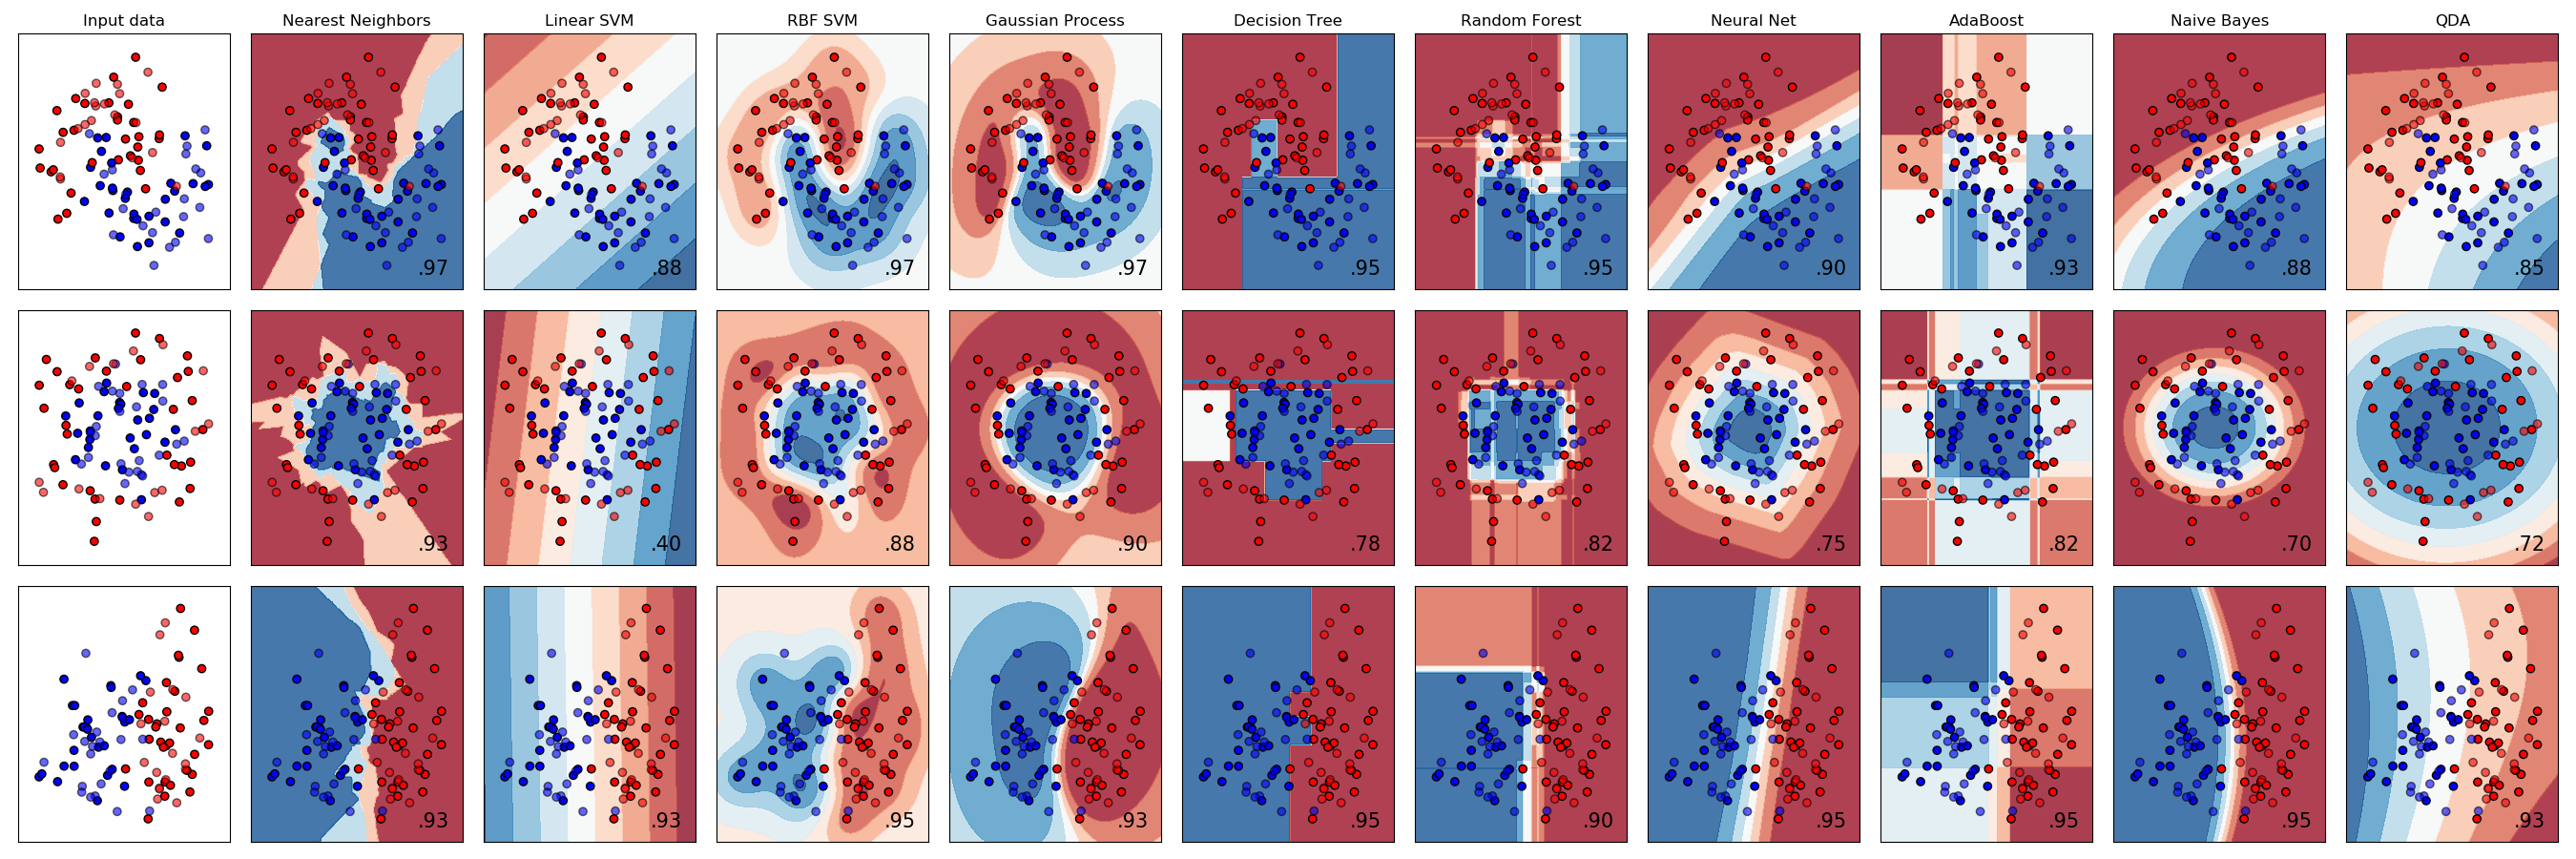

In [3]:
from IPython.core.display import Image
Image("http://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png", width=1000)

Un exemple fréquemment utilisé pour illustrer la difficulté du problème est celui de deux cercles concentriques (seconde ligne).

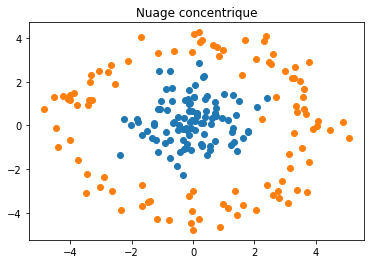

In [4]:
X1 = [ (random.gauss(0,1), random.gauss(0,1)) for i in range(0,100) ]
X2 = [ (random.gauss(4,0.5), random.random() * 2 * math.pi) for i in range(0,100) ]
X2 = [ (x[0]*math.cos(x[1]), x[0]*math.sin(x[1])) for x in X2 ]
Y1 = [ 0 for i in X1 ]
Y2 = [ 1 for i in X2 ]

plt.plot( [ x[0] for x in X1], [ x[1] for x in X1 ], "o")
plt.plot( [ x[0] for x in X2], [ x[1] for x in X2 ], "o")
plt.title("Nuage concentrique");

On applique un modèle linéaire simple : la régression logistique (assez semblable au modèle LDA = [Linear Discriminant Analysis](https://fr.wikipedia.org/wiki/Analyse_discriminante_lin%C3%A9aire)).

In [5]:
X = numpy.array( X1 + X2 )
Y = numpy.array( Y1 + Y2 )

In [6]:
import sklearn
from sklearn.linear_model import LogisticRegression
clr = LogisticRegression()
clr.fit(X,Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

La séparation opérée par le modèle est loin d'être optimale.

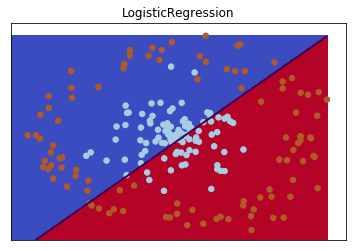

In [7]:
from matplotlib.colors import ListedColormap
import warnings

import numpy as np

def plot_clf_2classes(clf, X, y, title):
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max()
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()), 
               aspect='auto', origin='lower', cmap=plt.cm.coolwarm)
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        contours = ax.contour(xx, yy, Z, levels=[0], linewidths=2, linetypes='--')
    ax.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    return ax

plot_clf_2classes(clr, X, Y, "LogisticRegression");

On passe alors à un modèle toujours simple mais plus long à entraîner avec les [plus proches voisins](https://fr.wikipedia.org/wiki/M%C3%A9thode_des_k_plus_proches_voisins).

In [8]:
from sklearn.neighbors import KNeighborsClassifier
clr = KNeighborsClassifier()
clr.fit(X,Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

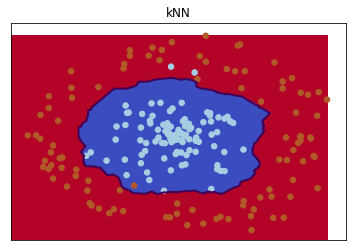

In [9]:
plot_clf_2classes(clr, X, Y, "kNN");

C'est nettement mieux mais le modèle n'est plus aussi interprétable que le précédent, il est nettement plus long à calculer. Plus la frontière entre les classes est grande, plus il faut d'exemples dans la base d'apprentissage. Les autres modèles (arbre de décision, réseaux de neurones) proposent des séparations plus ou moins proches de la solution optimale. Le modèle [SVC](http://scikit-learn.org/stable/modules/svm.html#svc) fonctionne bien sur ce problème.

In [10]:
from sklearn.svm import SVC
clr = SVC()
clr.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

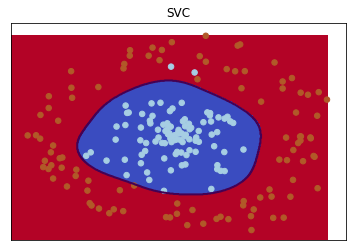

In [11]:
plot_clf_2classes(clr, X, Y, "SVC");

Cette approche est quelque peu séduisante. Elle donne l'impression qu'il suffit de parcourir la liste des modèles disponibles pour trouver celui qui convient le mieux. Sur un problème aussi simple et petit, cela ne pose pas de problème. Un très grand nombre d'observations réduit considérablement de choix. Les [plus proches voisins](https://fr.wikipedia.org/wiki/M%C3%A9thode_des_k_plus_proches_voisins) ou les [SVM](http://scikit-learn.org/stable/modules/svm.html#support-vector-machines) sont peu recommandés dans ce cas. Le nombre de variables ou features peut devenir un obstacle : en grande dimension, les algorithmes d'optimisation convergent moins bien.

Lorsque plus rien ne marche, il faut revenir aux données et essayer de comprendre pourquoi les modèles n'arrivent pas à _capturer_ l'information. On cherche alors à construire une combinaison non linéaire des variables initiales. Dans notre cas, il suffit d'ajouter les produits des variables initiales pour se ramener à un problème de classification linéaire : $x_1$, $x_2$, $x_1^2$, $x_2^2$, $x_1 x_2$.

In [12]:
Xext = numpy.zeros( (len(X), 5) )
Xext[:,:2] = X
Xext[:,2] =  X[:,0]**2
Xext[:,3] =  X[:,1]**2
Xext[:,4] =  X[:,0]*X[:,1]

In [13]:
clr = LogisticRegression()
clr.fit(Xext,Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
clr.coef_

array([[ 0.28889505, -0.05595533,  0.61486864,  0.48069645,  0.06631342]])

La fonction de dessin suivante reprend la précédente à ceci près que le nombre de features est plus grand sous pour autant modifier la projection qu'on souhaite obtenir qui considère toujours les deux variables initiales sans les variations polynômiales.

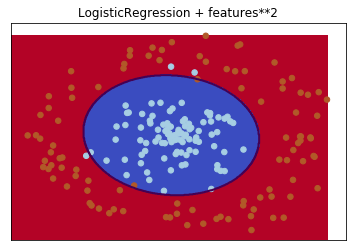

In [15]:
def plot_clf_2classes_poly(clf, X, y, title):
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max()
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max()

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), (xx*xx).ravel(), (yy*yy).ravel(), (xx*yy).ravel()])
    Z = Z.reshape(xx.shape)

    fig, ax = plt.subplots(1, 1)
    ax.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()), 
               aspect='auto', origin='lower', cmap=plt.cm.coolwarm)
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        contours = ax.contour(xx, yy, Z, levels=[0], linewidths=2, linetypes='--')
    ax.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    return ax

plot_clf_2classes_poly(clr, Xext, Y, "LogisticRegression + features**2");

Un problème qui n'était pas linéaire l'est devenu en ajoutant les bonnes features. D'une manière générale, il est utile d'essayer de convertir toute connaissance a priori d'un problème en features de façon à aider l'apprentissage d'un modèle. Le cas le plus fréquent est le calcul de statistiques exhaustive sur un groupe d'observations liées :

* On dispose de tous les achats des utilisateurs d'un site.
* On veut prédire la probabilité que l'utilisateur achète lors de sa prochaine visite.
* On utilise pour cela des moyennes calculées sur l'ensemble des achats précédents : on prédit au niveau *achat* avec des features calculées sur des groupes d'*achats*.

Pour aller plus loin, voir [Régression logistique, diagramme de Voronoï, k-Means](http://www.xavierdupre.fr/app/mlstatpy/helpsphinx/c_ml/lr_voronoi.html).